In [ ]:
!pip install music21 gensim librosa helpers
!apt install musescore3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libpoppler-qt5-1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5
  libqt5help5 libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-general-soundfont-small musescore3-common qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
from music21 import *
from helpers import *
from music21.repeat import Expander
from gensim.models import FastText
import numpy as np
import pickle
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio

In [ ]:
file_path = "drive/MyDrive/dependencies_pavane/pavane.mp3"
audio, sampling_rate = librosa.load(file_path)
Audio(audio, rate=sampling_rate)

<ipython-input-4-2a4465f72812>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sampling_rate = librosa.load(file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/dependencies_pavane/pavane.mp3'

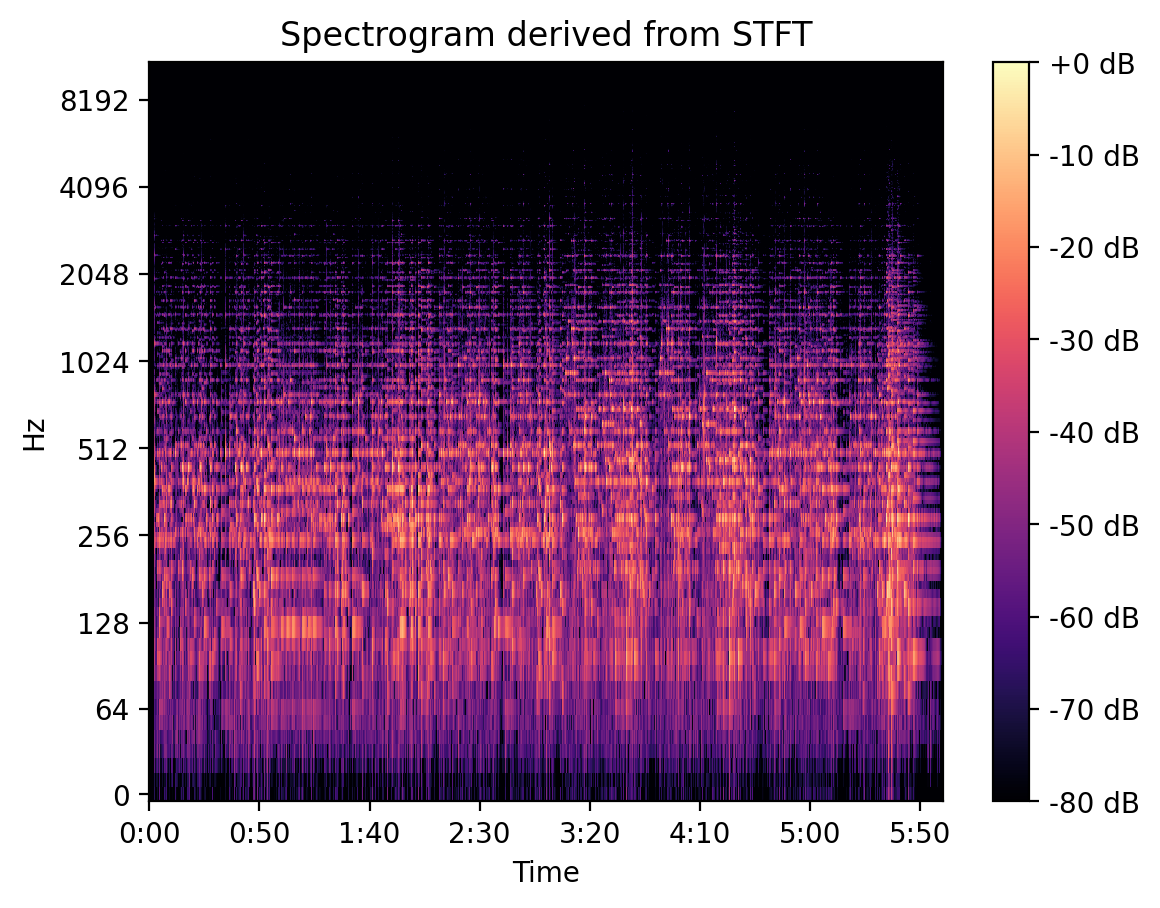

In [ ]:
def create_and_chart_spectrogram(audio, sampling_rate, hop_length):

    stft = librosa.stft(audio, hop_length=hop_length)

    spectrogram = np.abs(stft)

    librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time', sr=sampling_rate)


    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram derived from STFT')
    plt.show()

    return spectrogram

hop_length = 512 # lower = more granularity but more computational power. Must be positive int that is lower than n_fft parameter.
spectrogram = create_and_chart_spectrogram(audio, sampling_rate, hop_length)

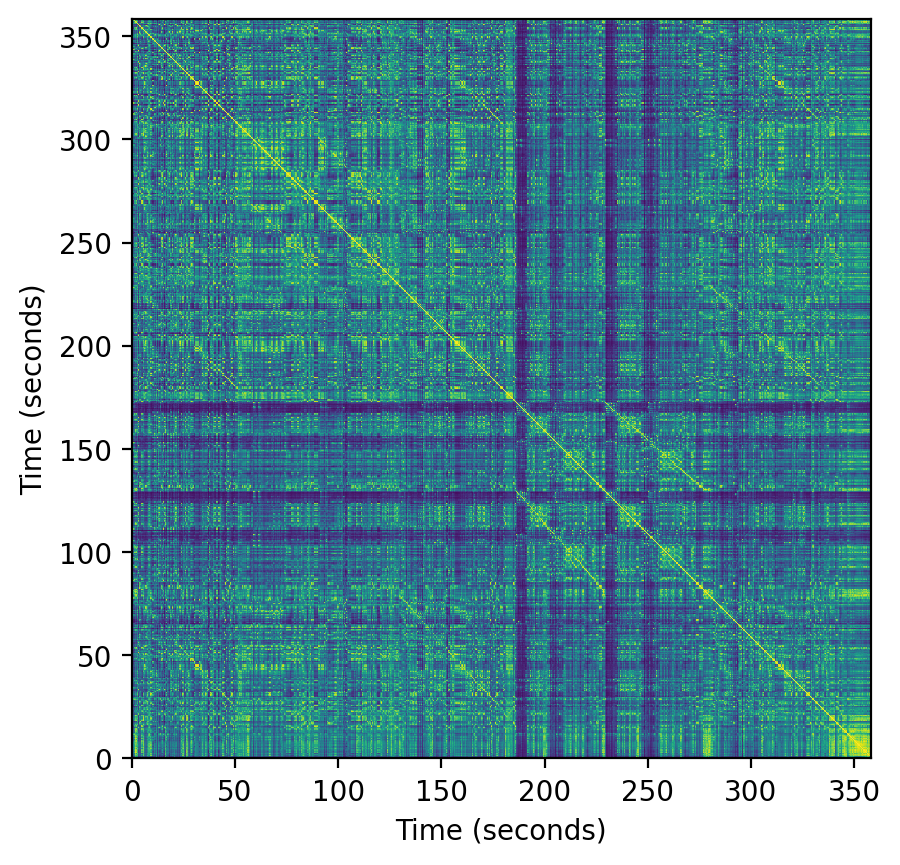

In [ ]:
def ssm_from_spectrogram(spectrogram):
    spectrogram_T = spectrogram.T # transpose to ensure row vectors represent frequency spectrum during given window
    spectrogram_T = np.delete(spectrogram_T, np.where((spectrogram_T == 0).all(axis=1))[0], axis=0) # delete moments with absolute 0 frequency spectrum (aka dead silence) to circumvent missing values in similarity calculation
    times = librosa.times_like(len(spectrogram_T), sr=sampling_rate, hop_length=hop_length) # used to map SSM axes to seconds

    from sklearn.metrics.pairwise import cosine_similarity
    self_sim_mat_aud = cosine_similarity(spectrogram_T)

    # Plot the SSM
    plt.figure()
    plt.imshow(self_sim_mat_aud, cmap='viridis', interpolation='nearest', extent=[times[0], times[-1], times[0], times[-1]])
    plt.xlabel('Time (seconds)')
    plt.ylabel('Time (seconds)')
    plt.show()

    return self_sim_mat_aud

self_sim_mat_aud = ssm_from_spectrogram(spectrogram)

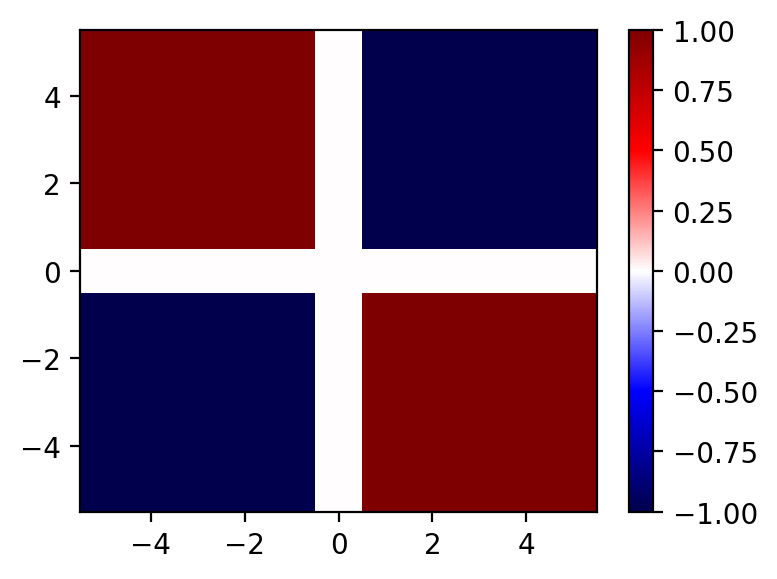

In [ ]:
def build_kernel(L):
    axis = np.arange(-L, L+1)
    kernel = np.outer(np.sign(axis), np.sign(axis))
    return kernel


L = 5
kernel = build_kernel(L)
plt.figure(figsize=(4,3))
plt.imshow(kernel, aspect='auto', extent=[-L-0.5,L+0.5,-L-0.5,L+0.5], cmap='seismic')
plt.colorbar()
plt.tight_layout()

In [ ]:
def novelty_from_ssm(SSM, L):
    kernel = build_kernel(L=L)
    N = SSM.shape[0]
    M = 2*L + 1
    novelty = np.zeros(N)
    S_padded = np.pad(SSM, L, mode='constant')
    for n in range(N):
        novelty[n] = np.sum(S_padded[n:n+M, n:n+M] * kernel)

    return novelty

def calculate_and_plot_novelty(self_sim_mat_aud, L_kernel):

    novelty = novelty_from_ssm(self_sim_mat_aud, L_kernel)

    # Create x-axis values
    x = np.arange(len(novelty))
    times = librosa.times_like(len(novelty), sr=sampling_rate, hop_length=hop_length)

    # Create a line plot
    plt.figure()
    plt.plot(times, novelty)

    plt.show()



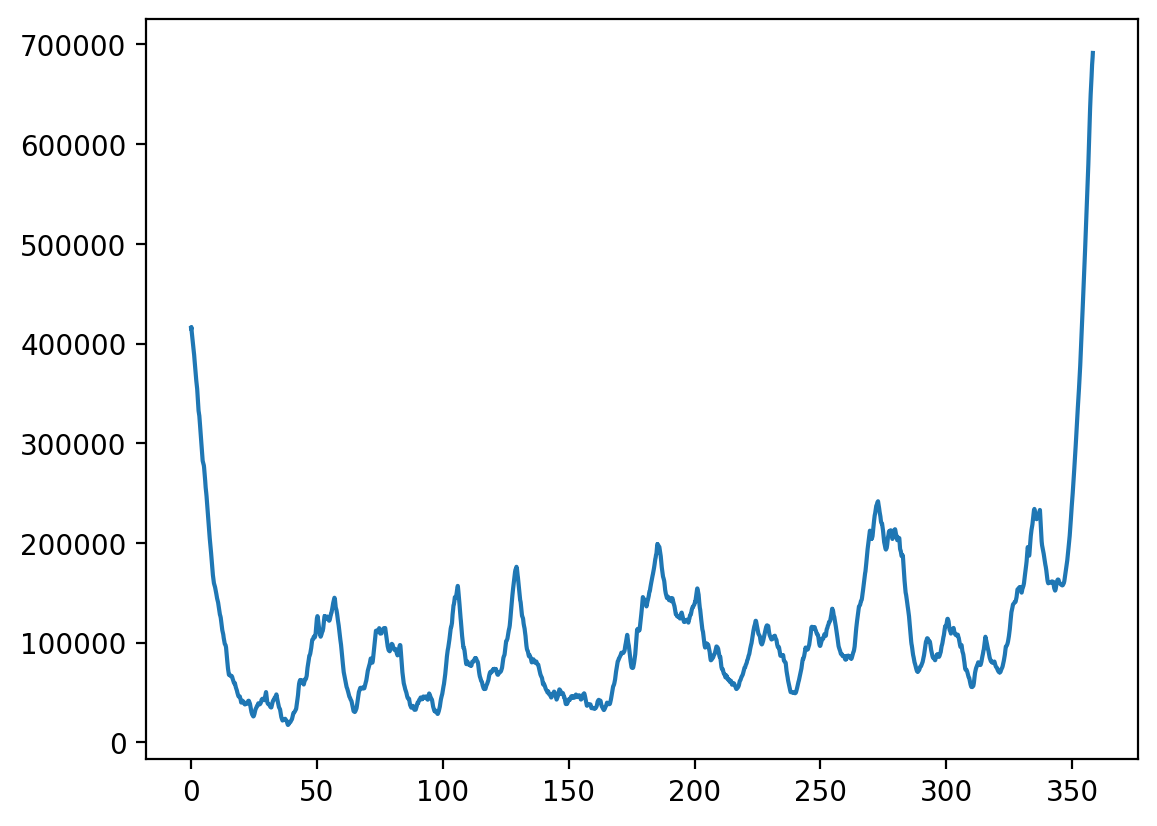

In [ ]:
calculate_and_plot_novelty(self_sim_mat_aud, 1000)


In [ ]:
import scipy
import math

def find_peaks(novelty, piece_len_sec):
  piece_len = piece_len_sec
  novelty_len = len(novelty)
  peaks = scipy.signal.find_peaks(novelty, prominence=70000)

  for p in peaks[0]:
    secs = (p*(360/len(novelty)))
    minutes = secs / 60
    seconds = secs % 60
    if seconds < 10:
      print(math.floor(minutes), ":0", math.floor(seconds))
    else:
      print(math.floor(minutes), ":", math.floor(seconds))

In [ ]:
novelty = novelty_from_ssm(self_sim_mat_aud, 1000)

find_peaks(novelty, 360)

0 : 57
1 : 17
1 : 46
2 :0 9
3 :0 6
4 : 34
5 : 36


In [ ]:
import music21
def ending_dim(score):
  diminuendos = []
  crescendos = []

  phrase_endings = []

  for i in range(len(score.parts[1])):
    for e in score.measure(i).recurse():
      if isinstance(e, music21.dynamics.Diminuendo):
        diminuendos.append(i)
        valid = True
        for j in range(i-4, i+1):
          if j in crescendos:
            valid = False
            break

        if valid:
         phrase_endings.append(i)

      if isinstance(e, music21.dynamics.Crescendo):
        crescendos.append(i)

  return phrase_endings

In [ ]:
def ending(score):
  measure_first = []
  measure_last_three = []

  for measure in score.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure):
      notes = []

      if measure.getElementsByClass(stream.Voice):
        for e in measure.getElementsByClass(stream.Voice)[0].recurse().notes:
          notes.append(e)

      else:
        for e in measure.recurse().notes:
          notes.append(e)

      if len(notes) >= 3:
        measure_last_three.append(notes[len(notes)-3:])
        measure_first.append([notes[0]])
      else:
        measure_last_three.append([])
        measure_first.append([])

  phrase_endings = []

  for i in range(len(measure_last_three) - 2):
    last_pitches = []

    if len(measure_last_three[i]) == 0 or len(measure_first[i+1]) == 0:
      continue

    last_three = measure_last_three[i]
    first_next = measure_first[i+1][0]

    for n in last_three:
      if isinstance(n, music21.chord.Chord):
        last_pitches.append(n[-1].pitch.midi)
      else:
        last_pitches.append(n.pitch.midi)

    if last_pitches[0] > last_pitches[1] > last_pitches[2] or last_pitches[0] < last_pitches[1] < last_pitches[2]:
      avg_dur = (last_three[0].duration.quarterLength + last_three[1].duration.quarterLength +last_three[2].duration.quarterLength)/3

      if first_next.duration.quarterLength > 1.75*avg_dur:
        phrase_endings.append(i+1)

  return phrase_endings


In [ ]:
import music21

score = converter.parse('drive/MyDrive/dependencies_pavane/pavane.musicxml')
all_phrase_endings = []
phrase_endings = []

all_phrase_endings += ending_dim(score)
all_phrase_endings += ending(score)
all_phrase_endings.sort()

start = 0
for p in all_phrase_endings:
  if p - start >= 5:
    phrase_endings.append(p)
    start = p

print(phrase_endings)

[1, 3, 4, 5, 7, 11, 13, 15, 17, 20, 22, 24, 25, 27, 28, 30, 31, 32, 34, 42, 46, 51, 52, 54, 56, 57, 60, 62, 63, 64, 66]
[5, 11, 17, 22, 27, 32, 42, 51, 56, 62]
